# This sorts the taxi data into zip codes of origin and destination

In [1]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

In [2]:
#reads in zipcode boundary geojson file
zipcodes = gpd.read_file('data/Chicago/Boundaries - ZIP Codes.geojson') 
print(zipcodes.crs)
zipcodes.head( )

epsg:4326


,objectid,shape_area,shape_len,zip,geometry
0,33,106052287.488,42720.0444058,60647,"MULTIPOLYGON (((-87.67762 41.91776, -87.67761 ..."
1,34,127476050.762,48103.7827213,60639,"MULTIPOLYGON (((-87.72683 41.92265, -87.72693 ..."
2,35,45069038.4783,27288.6096123,60707,"MULTIPOLYGON (((-87.78500 41.90915, -87.78531 ..."
3,36,70853834.3797,42527.9896789,60622,"MULTIPOLYGON (((-87.66707 41.88885, -87.66707 ..."
4,37,99039621.2518,47970.1401531,60651,"MULTIPOLYGON (((-87.70656 41.89555, -87.70672 ..."


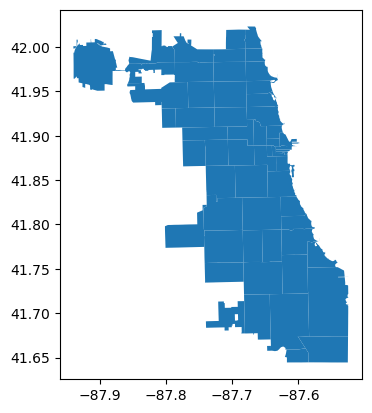

In [3]:
zipcodes.plot();

In [4]:
#drops unneeded zipcode columns
zipcodes = zipcodes[['zip', 'geometry']]

In [5]:
#reads in taxi data
taxis_from = pd.read_csv('data/Chicago/cleaned/taxis/taxis_clean_Q4.csv')
print(taxis_from.shape)
taxis_from.head(3)

(922206, 24)


,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,Community Areas
0,f8fad61a583724263dcc628c822ec835f212665d,081758ced4767105bfa217f7b0784d72d37e12a016fe2a...,12/31/2022 11:45:00 PM,01/01/2023 12:30:00 AM,3029.0,12.93,NaN,NaN,NaN,38.0,...,40.50,Cash,5 Star Taxi,NaN,NaN,NaN,41.812949,-87.617860,POINT (-87.6178596758 41.8129489392),NaN
1,e32619aecacfd5acbbf6f28d7e7a896ba29fc1c9,ca30b49aab641fe71294a9b03b991b968c7f3e47e11691...,12/31/2022 11:45:00 PM,01/01/2023 12:45:00 AM,3865.0,18.24,NaN,NaN,16.0,16.0,...,51.75,Cash,Sun Taxi,41.953582,-87.723452,POINT (-87.7234523905 41.9535821253),41.953582,-87.723452,POINT (-87.7234523905 41.9535821253),16.0
2,e030fd7f7823609387b04d407509a786e002888f,b71c6761efe32829e7e453b0c6fcb78a456a7d83c720c7...,12/31/2022 11:45:00 PM,01/01/2023 12:00:00 AM,767.0,2.39,NaN,NaN,8.0,24.0,...,10.25,Cash,Flash Cab,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.901207,-87.676356,POINT (-87.6763559892 41.9012069941),37.0


In [6]:
#renames columns
taxis_from = taxis_from.rename(columns={"Pickup Centroid Latitude": "lat", "Pickup Centroid Longitude": "lng"})
taxis_from

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Trip Total,Payment Type,Company,lat,lng,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,Community Areas
0,f8fad61a583724263dcc628c822ec835f212665d,081758ced4767105bfa217f7b0784d72d37e12a016fe2a...,12/31/2022 11:45:00 PM,01/01/2023 12:30:00 AM,3029.0,12.93,NaN,NaN,NaN,38.0,...,40.50,Cash,5 Star Taxi,NaN,NaN,NaN,41.812949,-87.617860,POINT (-87.6178596758 41.8129489392),NaN
1,e32619aecacfd5acbbf6f28d7e7a896ba29fc1c9,ca30b49aab641fe71294a9b03b991b968c7f3e47e11691...,12/31/2022 11:45:00 PM,01/01/2023 12:45:00 AM,3865.0,18.24,NaN,NaN,16.0,16.0,...,51.75,Cash,Sun Taxi,41.953582,-87.723452,POINT (-87.7234523905 41.9535821253),41.953582,-87.723452,POINT (-87.7234523905 41.9535821253),16.0
2,e030fd7f7823609387b04d407509a786e002888f,b71c6761efe32829e7e453b0c6fcb78a456a7d83c720c7...,12/31/2022 11:45:00 PM,01/01/2023 12:00:00 AM,767.0,2.39,NaN,NaN,8.0,24.0,...,10.25,Cash,Flash Cab,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.901207,-87.676356,POINT (-87.6763559892 41.9012069941),37.0
3,d664071f00fdd17a9bc8e09841de79c69223f175,ab172f16a0f2033e0fb3da3c21353da9704edb989c9b55...,12/31/2022 11:45:00 PM,01/01/2023 12:00:00 AM,603.0,2.01,NaN,NaN,32.0,28.0,...,14.42,Mobile,City Service,41.878866,-87.625192,POINT (-87.6251921424 41.8788655841),41.874005,-87.663518,POINT (-87.6635175498 41.874005383),38.0
4,c8ded4eb1a278ff9c1cdee84a3ba5f8fdc91fb85,f71223a469d78a2f65a090adc9d4fb5ae08dfc6694c650...,12/31/2022 11:45:00 PM,01/01/2023 12:15:00 AM,1180.0,9.27,NaN,NaN,8.0,1.0,...,25.00,Cash,Chicago Independents,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),42.009623,-87.670167,POINT (-87.6701668569 42.0096228806),37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
922201,f2ea9cc79178f0efa6bd6713bb60a53dfc2d5c65,6455d0f1dcef91a96b809e3a10bf57831f79dc5112f0dd...,10/01/2022 12:00:00 AM,10/01/2022 12:30:00 AM,1592.0,12.88,NaN,NaN,76.0,5.0,...,38.00,Cash,Sun Taxi,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),41.947792,-87.683835,POINT (-87.6838349425 41.9477915865),75.0
922202,f381a24b647f55021408a305b64e85e71a56853b,e533bfdc483206f9c02c1c879a118d88f0a3ca1cd2703f...,10/01/2022 12:00:00 AM,10/01/2022 12:30:00 AM,1568.0,18.36,NaN,NaN,NaN,8.0,...,52.00,Credit Card,Flash Cab,NaN,NaN,NaN,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),NaN
922203,fe33a650e73b0caa20b19126d876fc01c77b3e41,58c784c628cc2b0b77468e6a406acea729301abbc17a62...,10/01/2022 12:00:00 AM,10/01/2022 12:15:00 AM,984.0,8.48,NaN,NaN,3.0,28.0,...,28.20,Credit Card,Taxicab Insurance Agency Llc,41.965812,-87.655879,POINT (-87.6558787862 41.96581197),41.874005,-87.663518,POINT (-87.6635175498 41.874005383),31.0
922204,ff5588dcdeaa7d7d57ad07148327d34af046d60a,1f041942ef7c61fea34c62c89aea8231e4277ca158d54e...,10/01/2022 12:00:00 AM,10/01/2022 01:00:00 AM,3321.0,9.09,NaN,NaN,8.0,1.0,...,37.00,Prcard,Flash Cab,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),42.009623,-87.670167,POINT (-87.6701668569 42.0096228806),37.0


In [7]:
#creates column containing geopoints
taxis_from['from_geo'] = taxis_from.apply(lambda x: Point((float(x.lng), 
                                                         float(x.lat))), 
                                        axis=1)
taxis_from.head(3)

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Payment Type,Company,lat,lng,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,Community Areas,from_geo
0,f8fad61a583724263dcc628c822ec835f212665d,081758ced4767105bfa217f7b0784d72d37e12a016fe2a...,12/31/2022 11:45:00 PM,01/01/2023 12:30:00 AM,3029.0,12.93,NaN,NaN,NaN,38.0,...,Cash,5 Star Taxi,NaN,NaN,NaN,41.812949,-87.617860,POINT (-87.6178596758 41.8129489392),NaN,POINT (nan nan)
1,e32619aecacfd5acbbf6f28d7e7a896ba29fc1c9,ca30b49aab641fe71294a9b03b991b968c7f3e47e11691...,12/31/2022 11:45:00 PM,01/01/2023 12:45:00 AM,3865.0,18.24,NaN,NaN,16.0,16.0,...,Cash,Sun Taxi,41.953582,-87.723452,POINT (-87.7234523905 41.9535821253),41.953582,-87.723452,POINT (-87.7234523905 41.9535821253),16.0,POINT (-87.72345239000001 41.953582125)
2,e030fd7f7823609387b04d407509a786e002888f,b71c6761efe32829e7e453b0c6fcb78a456a7d83c720c7...,12/31/2022 11:45:00 PM,01/01/2023 12:00:00 AM,767.0,2.39,NaN,NaN,8.0,24.0,...,Cash,Flash Cab,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.901207,-87.676356,POINT (-87.6763559892 41.9012069941),37.0,POINT (-87.63330803700001 41.899602111)


In [8]:
#drops unneeded columns
taxis_from_geo = taxis_from[['Trip ID', 'from_geo']]
taxis_from_geo

,Trip ID,from_geo
0,f8fad61a583724263dcc628c822ec835f212665d,POINT (nan nan)
1,e32619aecacfd5acbbf6f28d7e7a896ba29fc1c9,POINT (-87.72345239000001 41.953582125)
2,e030fd7f7823609387b04d407509a786e002888f,POINT (-87.63330803700001 41.899602111)
3,d664071f00fdd17a9bc8e09841de79c69223f175,POINT (-87.625192142 41.878865584)
4,c8ded4eb1a278ff9c1cdee84a3ba5f8fdc91fb85,POINT (-87.63330803700001 41.899602111)
...,...,...
922201,f2ea9cc79178f0efa6bd6713bb60a53dfc2d5c65,POINT (-87.91362459600001 41.980264315)
922202,f381a24b647f55021408a305b64e85e71a56853b,POINT (nan nan)
922203,fe33a650e73b0caa20b19126d876fc01c77b3e41,POINT (-87.655878786 41.96581197)
922204,ff5588dcdeaa7d7d57ad07148327d34af046d60a,POINT (-87.63330803700001 41.899602111)


In [9]:
#creates geodataframe from taxi info
taxis_from_geo = gpd.GeoDataFrame(taxis_from_geo, 
                           crs = zipcodes.crs, 
                           geometry = taxis_from['from_geo'])

In [10]:
#sorts origin taxi info into zipcodes
from_by_zip = gpd.sjoin(taxis_from_geo, zipcodes, op = 'within')
from_by_zip = from_by_zip.rename(columns={"Trip ID": "trip_id", 'geometry': 'zip_geo', "zip": "from_zip"})
from_by_zip.head()

,trip_id,from_geo,zip_geo,index_right,from_zip
1,e32619aecacfd5acbbf6f28d7e7a896ba29fc1c9,POINT (-87.72345239000001 41.953582125),POINT (-87.72345 41.95358),38,60618
52,9240b708251d05e4c12ca4b5a662d17db39e319e,POINT (-87.72345239000001 41.953582125),POINT (-87.72345 41.95358),38,60618
96,29b0071c2556c96139e7618a49219c7ecb02c323,POINT (-87.72345239000001 41.953582125),POINT (-87.72345 41.95358),38,60618
126,7ef38b2d405865f8c6843804c65eb172a91c241f,POINT (-87.72345239000001 41.953582125),POINT (-87.72345 41.95358),38,60618
171,93e456ff5462016c43399a94cec68c80cf1fe998,POINT (-87.72345239000001 41.953582125),POINT (-87.72345 41.95358),38,60618


In [11]:
from_by_zip.from_zip.value_counts()

60666    227910
60610     92279
60604     55027
60616     54391
60611     44452
60638     41175
60607     39533
60657     30973
60601     21526
60614     20877
60603     14656
60640     14582
60661     14271
60619     12136
60660     11503
60637     10878
60622      9043
60618      8721
60628      8684
60653      8269
60645      8095
60649      6335
60654      6254
60617      6191
60626      5939
60625      5821
60643      5107
60605      5072
60647      4539
60609      4507
60615      4389
60621      3343
60631      3035
60644      2626
60608      2503
60620      1982
60612      1909
60646      1819
60630      1668
60623      1502
60641      1494
60629      1477
60659      1187
60639      1134
60636      1109
60633       988
60651       972
60632       886
60613       868
60652       705
60634       534
60624       466
60655       190
60642       176
60707       129
60656         4
Name: from_zip, dtype: int64

### The following repeats the same process for destination data

In [12]:
taxis_to = pd.read_csv('data/Chicago/cleaned/taxis/taxis_clean_Q4.csv')
print(taxis_to.shape)
taxis_to.head(3)

(922206, 24)


,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,Community Areas
0,f8fad61a583724263dcc628c822ec835f212665d,081758ced4767105bfa217f7b0784d72d37e12a016fe2a...,12/31/2022 11:45:00 PM,01/01/2023 12:30:00 AM,3029.0,12.93,NaN,NaN,NaN,38.0,...,40.50,Cash,5 Star Taxi,NaN,NaN,NaN,41.812949,-87.617860,POINT (-87.6178596758 41.8129489392),NaN
1,e32619aecacfd5acbbf6f28d7e7a896ba29fc1c9,ca30b49aab641fe71294a9b03b991b968c7f3e47e11691...,12/31/2022 11:45:00 PM,01/01/2023 12:45:00 AM,3865.0,18.24,NaN,NaN,16.0,16.0,...,51.75,Cash,Sun Taxi,41.953582,-87.723452,POINT (-87.7234523905 41.9535821253),41.953582,-87.723452,POINT (-87.7234523905 41.9535821253),16.0
2,e030fd7f7823609387b04d407509a786e002888f,b71c6761efe32829e7e453b0c6fcb78a456a7d83c720c7...,12/31/2022 11:45:00 PM,01/01/2023 12:00:00 AM,767.0,2.39,NaN,NaN,8.0,24.0,...,10.25,Cash,Flash Cab,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.901207,-87.676356,POINT (-87.6763559892 41.9012069941),37.0


In [13]:
taxis_to = taxis_to.rename(columns={"Dropoff Centroid Latitude": "lat", "Dropoff Centroid Longitude": "lng"})

In [14]:
taxis_to['to_geo'] = taxis_to.apply(lambda x: Point((float(x.lng), 
                                                         float(x.lat))), 
                                        axis=1)

In [15]:
taxis_to_geo = taxis_to[['Trip ID', 'to_geo']]

In [16]:
taxis_to_geo = gpd.GeoDataFrame(taxis_to_geo, 
                           crs = zipcodes.crs, 
                           geometry = taxis_to['to_geo'])

In [17]:
to_by_zip = gpd.sjoin(taxis_to_geo, zipcodes, op = 'within')
to_by_zip = to_by_zip.rename(columns={"Trip ID": "trip_id", 'geometry': 'zip_geo', "zip": "to_zip"})
to_by_zip.head()

,trip_id,to_geo,zip_geo,index_right,to_zip
0,f8fad61a583724263dcc628c822ec835f212665d,POINT (-87.61785967599999 41.812948939),POINT (-87.61786 41.81295),35,60653
50,b28192c404ea14ae231ff41d9c6788ca53ec279a,POINT (-87.61785967599999 41.812948939),POINT (-87.61786 41.81295),35,60653
277,91fe1e87d8509ef394854bbd16ef906a7ceb7bd1,POINT (-87.61785967599999 41.812948939),POINT (-87.61786 41.81295),35,60653
282,8681e93e5314c482ba7749655a3dc7b0fd6bfc92,POINT (-87.61785967599999 41.812948939),POINT (-87.61786 41.81295),35,60653
308,1f3718df445541b9d2c245c86dda7a5a0e2f6f9d,POINT (-87.61785967599999 41.812948939),POINT (-87.61786 41.81295),35,60653


### Next, the origin and destination datasets will be merged and filtered for trips between different zip codes

In [18]:
trips_by_zip = from_by_zip.merge(to_by_zip, left_on='trip_id', right_on='trip_id')

In [19]:
trips_by_zip = trips_by_zip[['trip_id', 'from_zip', 'to_zip']]
trips_by_zip

,trip_id,from_zip,to_zip
0,e32619aecacfd5acbbf6f28d7e7a896ba29fc1c9,60618,60618
1,9240b708251d05e4c12ca4b5a662d17db39e319e,60618,60618
2,29b0071c2556c96139e7618a49219c7ecb02c323,60618,60646
3,7ef38b2d405865f8c6843804c65eb172a91c241f,60618,60646
4,93e456ff5462016c43399a94cec68c80cf1fe998,60618,60660
...,...,...,...
760017,20f96ff54a7e7eea82e3bf3afaeaa60c7856c0a6,60642,60616
760018,b484f1bc483949c5431ba0cfc40bb6253498187d,60642,60611
760019,c3c8b469031c4fe9eb53f5b5d828afeb639c0a3b,60656,60661
760020,98c0e40b9b77c0838b029255357bfe150e779814,60656,60654


In [20]:
#displays how many trips stay in the same zipcode
trips_by_zip.loc[trips_by_zip.from_zip == trips_by_zip.to_zip] 

,trip_id,from_zip,to_zip
0,e32619aecacfd5acbbf6f28d7e7a896ba29fc1c9,60618,60618
1,9240b708251d05e4c12ca4b5a662d17db39e319e,60618,60618
8,ede094929a5606cf33784aebd731c7457072a59d,60618,60618
9,487e130c8b977bf0727debb60bda6c0b5cb3021b,60618,60618
30,4de1ecacb08adfa138b6aa4d133fe1dfca7af41e,60618,60618
...,...,...,...
759478,78eb70ab55371a00ffaea233ec5e92dc2dd2ed31,60659,60659
759487,b6f04179d4b622eafc41c250cd7d4c76814810e5,60659,60659
759646,5c9ebae38cb292b9513879f9979bbae049ab104a,60707,60707
759820,fa17ed68964246a959ecaf8ff4caf832c1f627b7,60655,60655


In [21]:
#save the trips that are between zip codes
diff = trips_by_zip.loc[trips_by_zip.from_zip != trips_by_zip.to_zip] 

In [22]:
#counts the number of trips between each pair of zip codes
trip_count = diff[['from_zip', 'to_zip']].value_counts().reset_index(name='count')

In [23]:
trip_count['from_zip'] = trip_count.from_zip.astype(str)
trip_count['to_zip'] = trip_count.to_zip.astype(str)

In [24]:
trip_count.to_csv('data/Chicago/cleaned/taxis/taxis_count_Q4.csv', index=False)